## Flood Risk Reduction Evaluation and Screening

<p><b>FLORES</b> is a fast flood risk screening model, aimed at providing useful information early in the decision-making process for flood-prone cities. It simulates and evaluates the impact of many alternative flood risk reduction strategies, each consisting of a combination of measures.Basic formulas are used instead of more complex hydraulic modelling software, to reduce computation time, and to allow the model to run on a personal computer.</p> 

<p> 
<ul style="list-style-type: circle;">
<li><b>Multiple flood hazards;</b> Considers multiple flood hazards: coastal flooding, river flooding, and urban flooding. Also storms can be simulated that compound the effects of multiple hazards,</li>
<li><b>Combining structural and non-structural measures;</b> The FLORES model takes various methods of reducing flood risk into account. Including: coastal protection, storm surge barriers, drainage, retention, urban planning, early warning systems,</li>
<li><b>Multiple performance metrics for comparison;</b> As most decisions are not made solely based on economic arguments, flood risk reduction strategies are assessed based on multiple parameters,</li>
<li><b>Multi-purpose evaluation techniques;</b> Early in design, many stakeholders are involved. A wide range of different analysis tools is available, in order to tailor the type of analysis to the specific needs of the user. This can range from finding correlations and trade-offs, to scenario discovery or more sophisticated robust decision making tools. These tools are provided through the use of the EMA-workbench (Kwakkel, 2017),</li>
<li><b>Limited data requirements;</b> Many flood-prone cities are located in regions that lack reliable data. The model focusses on the conceptual design phase, where detailed results are not expected yet. Therefore, it is built to work with widely-available (open) data sets.</li>
<li><b>Generic setup;</b> The FLORES model aims to be used in a wide variety of situations and areas. It is therefore developed as a generic model, consisting of separate modules, where no additional coding is required. The model only requires processing of the local characteristics, partly by using GIS-tools.</li>  
</ul>
</p>

<p> The FLORES model has been developed at Delft University of Technology, Department of Hydraulic Engineering, in cooperation with GFDRR and the World Bank Group <b>(van Berchum, 2019)</b>. Parts of the model have been developed in previous research, in cooperation with Texas A&M University Galveston <b>(van Berchum and Mobley, 2017)</b></p>

<p> This notebook runs through the entire model, including installation, input data, simulation, and several analyses. It requires no previous installation, besides Python 3 and Jupyter Notebook. Throughout the walkthrough, multiple packages will be downloaded, most notably the EMA-workbench.</p>

<p>Version FLORES model: 0.3 (first generic version)<br/>
    Version EMA-workbench: 2.1</p>

Last Updated: 10-10-2018


## 1. Download and installation model

<p>Here, we download the main model components:<br/><br/>
FLORES, available on Github <br/>
EMA-workbench, available on pip <br/></p>

<p>build correct folder structure for analysis:<br/>    
<ul style="list-style-type: circle;">
<li>data,</li> 
<li>figs,</li>  
<li>Library,(input data folder, FLORES python files)</li>  
<li>analysis notebook,</li>  
<li>runner notebook</li> 
</ul></p>


In [1]:
from pathlib import Path
import os
source_path = Path().home() / 'src'
os.chdir(source_path) 
print(source_path)      
    
from ema_workbench import (CategoricalParameter, RealParameter, ScalarOutcome, Constant, ReplicatorModel, ema_logging, MultiprocessingEvaluator, SequentialEvaluator, save_results)
from FLORES_tools.Library.flood_simulation_model import (FloodSimModel, process_risk, pick_one, process_affected_people, SimulationInput)
import rasterio
from datetime import date
%matplotlib inline
from matplotlib import pyplot
from IPython.display import Image
from timeit import default_timer as timer
import sys

D:\TU Delft\GitHub\FLORES-beira\src


C:\Program Files\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Program Files\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## 2. Import case study data

<p> Before we run the screening tool, the input data needs to be uploaded into the model. The repository, which also contains this notebook, has a library of data that can be used for simulation and screening. It is possible to choose different datasources. Below, the following data sources will be mentioned:</p>

   
<ul style="list-style-type: circle;">
    <li><b>DEM</b> digital elevation model. this layer is the base of all the data, as most of the calculations and exposure data depends or is linked to the elevation</li> 
    <li><b>City schematization</b> here, the city is divded into drainage basins and layers of defense, based on the DEM. </li>  
    <li><b>Exposure</b> This represents the people and structures that are potentially exposed to flooding. The damage curves are also chosen here.</li>  
<li><b>Flood risk reduction measures</b>. The table shows all measures that can be taken into account.</li>  
    <li><b>Hazard data</b> This contains all information on the incoming storm and rainfall events</li> 
    <li><b>Future scenarios</b> This data accounts for the effects of climate change and future urban development. Because this is mostly uncertain, different scenarios are identified.</li>
</ul></p>




In [2]:
dir_name_data = source_path / 'Projects' / 'FLORES_beira' / 'input_data'
print(dir_name_data)
flores_sim = FloodSimModel()

D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data


D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data\schematization\lidar\data


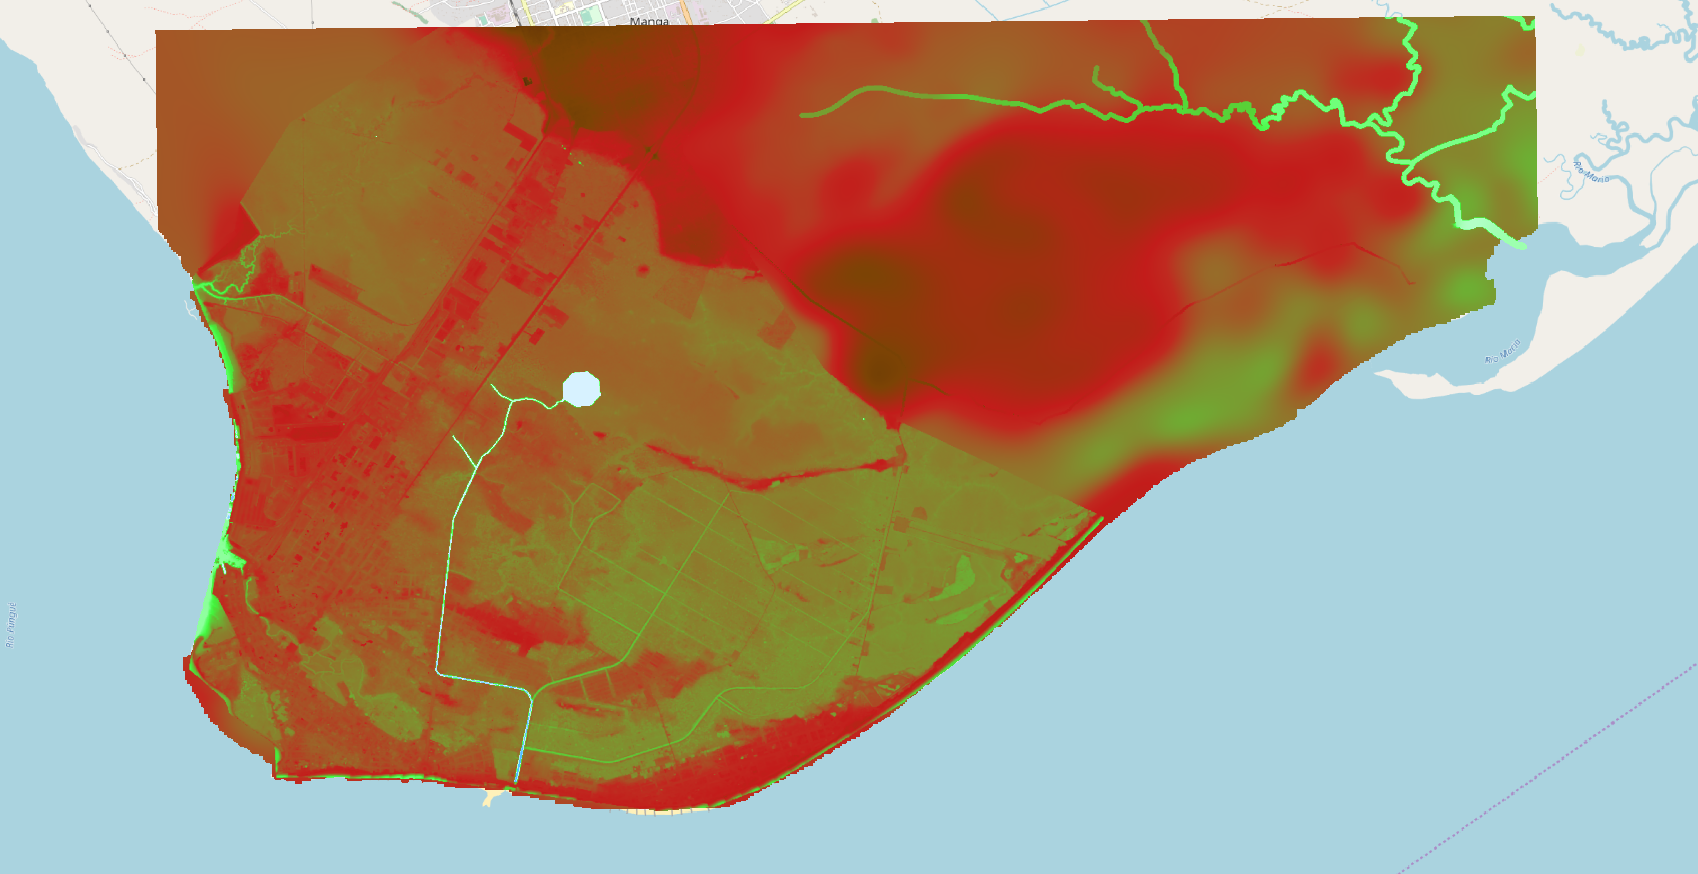

In [3]:
# Make choice for DEM
flores_dem = 'lidar'
suffix_dem = '.png'
dem_folderpath = dir_name_data.joinpath('schematization/' + flores_dem)
dem_plotfile = str(dem_folderpath.joinpath(flores_dem + suffix_dem))
dem_datafolder = dem_folderpath.joinpath('data')
print(dem_datafolder)
Image(dem_plotfile)
#src = rasterio.open(dem_plotfile)
#pyplot.imshow(src.read(1))
#pyplot.show()

### City schematization

<p>GIS-based computations are often computationally very demanding. Therefore, the area will be schematized to speed up the simulation. Within the FLORES model, the city will be schematized as a number of <b>drainage basins</b>. A drainage basin is defined as the area where water drains towards the same location, i.e. the lowest point in that specific area. This way, the local topography of the city, with local depressions, is accounted for. The hydraulic simulation of a storm and/or rainfall event revolves around the (connected) volume balances of these drainage basins. This type of simulation has many similarities with other Rapid Flood Inundation Models (RFIM) as proposed by Shen et al. (2016), Liu and Pender (2010) and Lhomme et al. (2008). In the FLORES Flood simulation, this volume balance is expanded by taking into account rainfall, infiltration, drainage, retention and surface flow between drainage basins.</p>

<p>Moreover, when a city is also threatened by storm surge, <b>lines of defense</b> (e.g. coastline, riverbank) are also defined and the water flowing across such a line of defense is modelled as inflow for the affected drainage basins. This volume balance will be repeated for each basin and for every timestep throughout the flood event.</p>

D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data\schematization\lidar\lidar_basins.PNG
D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data\schematization\lidar\lidar_lines_of_defense.PNG


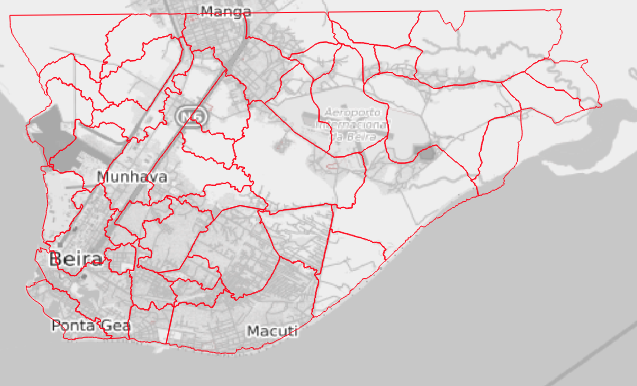

In [4]:
# Show schematization
suffix_plot = '.PNG'
suffix_data = '.csv'
basin_plotfile = str(dem_folderpath.joinpath(flores_dem + '_basins' + suffix_plot))
LOD_plotfile = str(dem_folderpath.joinpath(flores_dem + '_lines_of_defense' + suffix_plot))
basin_datafile = str(dem_datafolder.joinpath(flores_dem + '_basins' + suffix_data))
LOD_datafile = str(dem_datafolder.joinpath(flores_dem + '_lines_of_defense' + suffix_data))
basin_borders_datafile = str(dem_datafolder.joinpath(flores_dem + '_basin_borders' + suffix_data))
basin_drainage_datafile = str(dem_datafolder.joinpath(flores_dem + '_basin_drainage' + suffix_data))
flores_sim.save_source('basins', basin_datafile)
flores_sim.save_source('layers', LOD_datafile)
flores_sim.save_source('basin_borders', basin_borders_datafile)
flores_sim.save_source('basin_drainage', basin_drainage_datafile, 'yes')

print(basin_plotfile)
print(LOD_plotfile)

Image(basin_plotfile)


## Exposure

<p>The impact calculation is based on people and structures exposed to inundation caused by the storm. There is spatial data available on population and structural value. By combining this data with the DEM, csv-datafiles are built containing population numbers and structural value for individual drainage basins, and for different elevation levels within. 
</p>

Datasource was already defined. new data source overwrites the previous one.
Datasource was already defined. new data source overwrites the previous one.
D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data\schematization\lidar\data\exposure\ADFR_str\ADFR_str.PNG


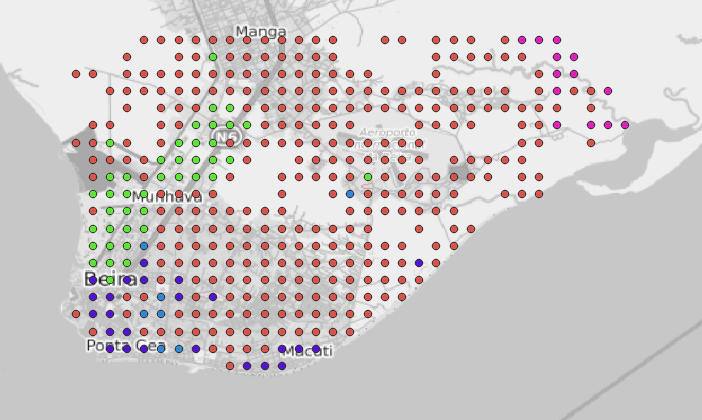

In [6]:
pop_source = 'ADFR_pop'
str_source = 'ADFR_str'
folder_exposure = 'exposure'
suffix_plot = '.tif'
suffix_data = '.csv'
exposure_folderpath = dem_datafolder.joinpath(folder_exposure)
pop_folder = exposure_folderpath.joinpath(pop_source)
str_folder = exposure_folderpath.joinpath(str_source)
pop_plotfile = str(pop_folder.joinpath(pop_source + suffix_plot))
structures_plotfile = str(str_folder.joinpath(str_source + '.PNG'))
pop_datafile = str(pop_folder.joinpath(pop_source + suffix_data))
str_datafile = str(str_folder.joinpath(str_source + suffix_data))
flores_sim.save_source('population', pop_datafile)
flores_sim.save_source('structures', str_datafile, 'yes')
# Image(str_plotfile)
# src_pop = rasterio.open(pop_plotfile)
# pyplot.imshow(src_pop.read(1))
# pyplot.show()
print(structures_plotfile)
Image(structures_plotfile)

<p> The damage to exposed structures is measured with the use of <b> damage curves</b>. These curves give the amount of damage as a result of a given inundation depth. damage curves are available for different land use types. Please note that these figures are used to calculate the expected value of structural damage. The amount of people affected uses a simplified definition, where a person is 'affected' when the water level in the residence rises above 10 cm.
</p>

In [6]:
dam_curve_source = "damage_curves_JRC"
suffix_dam_curve = ".xlsx"
dam_curve_file = str(dir_name_data.joinpath('schematization/' + dam_curve_source + suffix_dam_curve))
flores_sim.save_source('damage_curves', dam_curve_file, 'yes')
print(dam_curve_file)


D:\TU Delft\GitHub\FLORES-beira\src\Projects\FLORES_beira\input_data\schematization\damage_curves_JRC.xlsx


## Flood risk reduction measures (Aanvullen)

<p> A flood risk reduction strategy consists of a combination of potential measures. In order to represent the full array of options for flood risk management, many different types of measures are included. Measures can affect different parts of the model. </p>

<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 5px;
  text-align: left;    
}
</style>
</head>
<body>

<table style="width:100%">
  <tr>
    <th>Type</th>
    <th>Measure</th>
    <th>Location</th>
    <th>Costs</th>
    <th>Remarks</th>
  </tr>
  <tr>
    <td rowspan="4">Coastal structures</td>
    <td>Coastal dike - East</td>
    <td>Eastern coast</td>
    <td>2 million USD</td>
    <td>Possible heights: 7.0;7.5;8.0;8.5;9.0;9.5 m</td>
  </tr>
  <tr>
    <td>Coastal dike - West</td>
    <td>Western coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
    <td>Coastal dunes - East</td>
    <td>Eastern coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
    <td>Floodwall - West</td>
    <td>Western coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
      <td rowspan="2">Coastal dike - West</td>
      <td>Western coast</td>
      <td>4 million USD</td>
    </tr>
  <tr>
      <td>Coastal dike - West</td>
      <td>Western coast</td>
      <td>4 million USD</td>
    </tr>
</table>



First, we will run a single simulation to look at its effects. Therefore, it is necessary to choose a strategy, consisting of a combination of flood risk reduction measures. Below, all locations where measures can be placed are listed. The options are listed at the appropriate location and correspond to the measures in the table above.

In [7]:
measures_source = 'flood_risk_reduction_measures'
suffix_measures_data = '.csv'
measures_datafile = str(dir_name_data.joinpath('measures/' + measures_source + suffix_measures_data))
flores_sim.save_source('measures', measures_datafile, 'yes')

flores_sim.define_active_measures(CD_1=True,
                                  CD_2=True,
                                  CD_3=True,
                                  CD_4=True,
                                  SM_1=True,
                                  DR_1=True,
                                  DR_2=True,
                                  RT_1=True,
                                  RT_2=True,
                                  EM_1=True,
                                  EM_2=True
                                  )



## Import storm data

<p>
The simulation is centered around the effects of an incoming storm. In the current FLORES model, it is possible to take into account the effects of <b>coastal storm surge</b> and <b>extreme rainfall</b>. These hazards can occur separately or together, as would be the case during a cyclone event. The severity of the storm is measured in the return period of the underlying hazard. For example, a cyclone can lead to 100-year storm surge and a 10-year rainfall event.</p>

<p> Coastal storm surge is simulated in the form of a time series of water levels along the coast. All transitioning from deep sea to nearshore conditions is done beforehand. The length of the storm can vary. As time series of storms are often scarse, time series of historic events are scaled, depending on the highest reached water levels.</p>

<p>Rainfall is much more random to simulate, as each rainfall event can show a totally different time series of rainfall intensity. It is therefore unnecessary and unrealistic to base time series on past events, which is why a constant time series will be used. When no information is available about local hotspots that receive significantly higher amounts of rainfall, the spatial distribution is also constant. </p> 

<p>By choosing a source and plotting the result, you can see the rainfall duration-intensity curves and the 100 year storm surge time series.</p>


In [8]:
rain_source = 'study_chiveve'
ss_source = 'SS'
folder_hazard = 'hazards'
suffix_plot = '.jpg'
suffix_data = '.csv'
hazard_folderpath = dir_name_data.joinpath(folder_hazard)
rain_plotfile = str(hazard_folderpath.joinpath('rainfall_' + rain_source + suffix_plot))
ss_plotfile = str(hazard_folderpath.joinpath('surge_' + ss_source + suffix_plot))
rain_datafile = str(hazard_folderpath.joinpath('rainfall_' + rain_source + suffix_data))
ss_datafile = str(hazard_folderpath.joinpath('surge_' + ss_source + suffix_data))

flores_sim.save_source('hazard_rain', rain_datafile)
flores_sim.save_source('hazard_surge', ss_datafile, 'yes')

## Future scenarios

<p>The change of a city over time can greatly affect the impact of implementing flood risk reduction measures. Likewise, changes to hazard intensity - due to climate change - can greatly change the situation. It is therefore crucial to look at flood risk reduction in the context of changing circumstances and a changing city. Looking at all possible futures, in order to find the strategy that fits all possible futures, is at the heart of <b> Robust Decision Making</b>. With the use of the screening tool and analysis tools provided by the EMA-workbench, it is possible to pursue robust solutions.</p>

<p>In this case study, only the effects of climate change can be altered, in order to see its effect on the risk profile. Urban development is also added to the model. However, because it is connected to land use types, which don't very much throughout the city, varying the urban development predictions provides no new information.</p>

In [9]:
climate_source = 'IPCC'
urban_source = 'GOV'
folder_scenarios = 'scenarios'
suffix_scenarios_data = '.csv'
scenarios_folderpath = dir_name_data.joinpath(folder_scenarios)
climate_scenarios_data = str(scenarios_folderpath.joinpath('climate_' + climate_source + suffix_scenarios_data))
urban_scenarios_data = str(scenarios_folderpath.joinpath('urban_dev_' + urban_source + suffix_scenarios_data))
flores_sim.save_source('climate_scenarios', climate_scenarios_data)
flores_sim.save_source('urban_development_scenarios', urban_scenarios_data, 'yes')

All sources defined. Importing datasets.


## Simulate storm

Before the screening, we can first have a look at one simulation. The model below is feeded all information from the choices above. But first, a flood risk reduction strategy, storm conditions, and future conditions is required.

- geef resultaten en overstromingskaart

In [10]:
from FLORES_tools.Library.flood_simulation_model import SimulationInput

sim_imput = SimulationInput(return_period_storm_surge=5,
                            return_period_rainfall=10,
                            flood_risk_reduction_strategy=['CD_1', 'DR_1'],
                            future_scenario="high",
                            structural_heights={'CD_1': 9}
                            )


simulation, results, floodmap = flores_sim.run_simulation(sim_imput)

## 4 Screen flood risk reduction stategies

- make choice on number of storms to use, which measures to compare, how many strategies to compare
- Run model


In [11]:
'''
Created on

.. codeauthor:: jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>
'''


if __name__ == '__main__':

    ema_logging.log_to_stderr(level=ema_logging.INFO)
    flores_screen = ReplicatorModel('Beira', function=flores_sim.screening_simulation_model)

    flores_screen.replications = [{"return_period_rainfall": 100, "return_period_storm_surge": 100},
                                    {"return_period_rainfall": 50, "return_period_storm_surge": 100},
                                    {"return_period_rainfall": 10, "return_period_storm_surge": 100},
                                    {"return_period_rainfall": 5, "return_period_storm_surge": 100},
                                    {"return_period_rainfall": 0, "return_period_storm_surge": 100},
                                    {"return_period_rainfall": 100, "return_period_storm_surge": 50},
                                    {"return_period_rainfall": 50, "return_period_storm_surge": 50},
                                    {"return_period_rainfall": 10, "return_period_storm_surge": 50},
                                    {"return_period_rainfall": 5, "return_period_storm_surge": 50},
                                    {"return_period_rainfall": 0, "return_period_storm_surge": 50},
                                    {"return_period_rainfall": 100, "return_period_storm_surge": 10},
                                    {"return_period_rainfall": 50, "return_period_storm_surge": 10},
                                    {"return_period_rainfall": 10, "return_period_storm_surge": 10},
                                    {"return_period_rainfall": 5, "return_period_storm_surge": 10},
                                    {"return_period_rainfall": 0, "return_period_storm_surge": 10},
                                    {"return_period_rainfall": 100, "return_period_storm_surge": 5},
                                    {"return_period_rainfall": 50, "return_period_storm_surge": 5},
                                    {"return_period_rainfall": 10, "return_period_storm_surge": 5},
                                    {"return_period_rainfall": 5, "return_period_storm_surge": 5},
                                    {"return_period_rainfall": 0, "return_period_storm_surge": 5},
                                    {"return_period_rainfall": 100, "return_period_storm_surge": 0},
                                    {"return_period_rainfall": 50, "return_period_storm_surge": 0},
                                    {"return_period_rainfall": 10, "return_period_storm_surge": 0},
                                    {"return_period_rainfall": 5, "return_period_storm_surge": 0},
                                    {"return_period_rainfall": 'INFO', "return_period_storm_surge": 'INFO'}]

    leverlist = []
    for measure in flores_sim.AllMeasures:
        leverlist.append(CategoricalParameter(measure, [True, False]))
        if flores_sim.AllMeasures[measure].Type == 'Structural':
            structure_heights_min_max = [flores_sim.AllMeasures[measure].StructureHeights[0],
                                         flores_sim.AllMeasures[measure].StructureHeights[-1]]
            leverlist.append(RealParameter('height-' + measure, flores_sim.AllMeasures[measure].StructureHeights[0],
                                       flores_sim.AllMeasures[measure].StructureHeights[-1]))

    flores_screen.levers = leverlist

    flores_screen.constants = [Constant('urban_development_scenario', 'low')]

    flores_screen.uncertainties = [CategoricalParameter('climate_scenario', ['low', 'high'])]

    flores_screen.outcomes = [ScalarOutcome("risk_reduction", function=process_risk),
                                ScalarOutcome("construction_costs", function=pick_one),
                                ScalarOutcome("affected_pop_reduction", function=process_affected_people)]

    nr_strategies = 25

    today = date.today()


    fn = ('Projects/FLORES_beira/data/{0} experiments_FLORES_{1}_{2}.tar.gz'.format(nr_strategies, 'Beira', today))
    print('ready for screening')

ready for screening


In [ ]:
start = timer()
 
if not os.path.exists(source_path.joinpath(fn)):
    with SequentialEvaluator(flores_screen) as evaluator:
        results = evaluator.perform_experiments(scenarios=2, policies=nr_strategies,
                                                    uncertainty_sampling='ff', reporting_interval=1)
save_results(results, fn)
print("done")
end = timer()
print(end - start)

# 5 Flood Risk Analysis

With the use of the screening tool, many flood risk reduction strategies have been simulated. Next, we will use a selection of tools to analyze the results.

In [2]:
from os import listdir

data_directory = source_path / 'Projects' / 'FLORES_beira' / 'data'
listdir(data_directory)

['200 experiments_MODOS_Beira_28_11-2_scenarios.tar.gz',
 '25 experiments_FLORES_Beira_2019-11-16.tar.gz',
 '250 experiments_MODOS_Beira_20_09_storm100_2_scenarios.tar.gz',
 '500 experiments_MODOS_Beira_24_09_storm10_2_scenarios.tar.gz',
 '500 experiments_MODOS_Beira_30_11-2_scenarios.tar.gz']

In [3]:
from ema_workbench import load_results
str_path_results = str(data_directory.joinpath('25 experiments_FLORES_Beira_2019-11-16.tar.gz'))
results = load_results(str_path_results)
experiments, outcomes = results
print(experiments.shape)
print(list(outcomes.keys()))

(50, 20)
['risk_reduction', 'construction_costs', 'affected_pop_reduction']


C:\Program Files\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


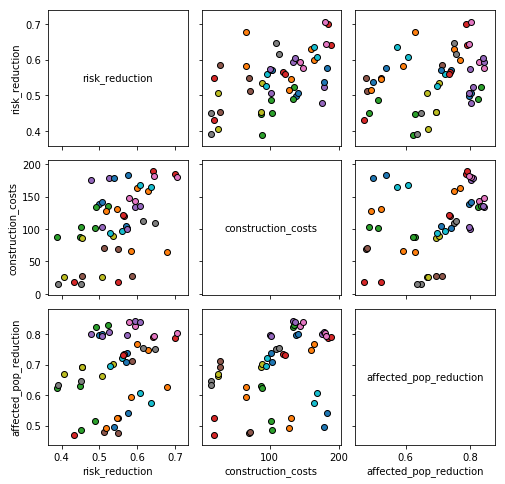

In [4]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy', 
                                         legend=False)
fig.set_size_inches(8,8)
pyplot.show()

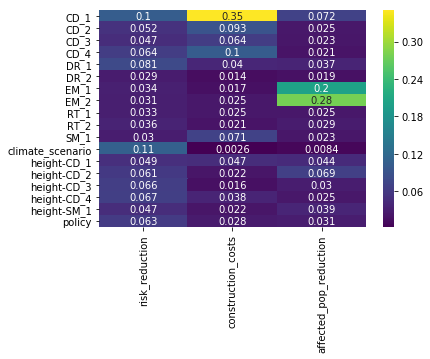

In [5]:
#import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
import seaborn as sns
#results_update = results.where((pd.notnull(results)),'none')

#experiments = rf.drop_fields(experiments, ['policy'], asrecarray=True)

x = experiments
y = outcomes

# focus dataset on 1 climate scenario
#x_bool = x[x_bool==1]
#y_new = y[x_bool==1]

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
pyplot.show()

In [6]:
from ema_workbench.analysis import prim
b1= outcomes['risk_reduction'] > 0.40
b2= outcomes['construction_costs'] < 125
b3= outcomes['affected_pop_reduction'] > 0.65
b4= x['climate_scenario'] == 'low'

y = b1 & b2 & b3 &b4

prim_alg = prim.Prim(x,y, threshold=0.7)
box1 = prim_alg.find_box()

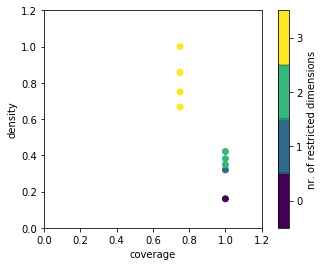

In [7]:
box1.show_tradeoff()
pyplot.show()

climate_scenario ['low', 'high']
EM_2 [True, False]


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


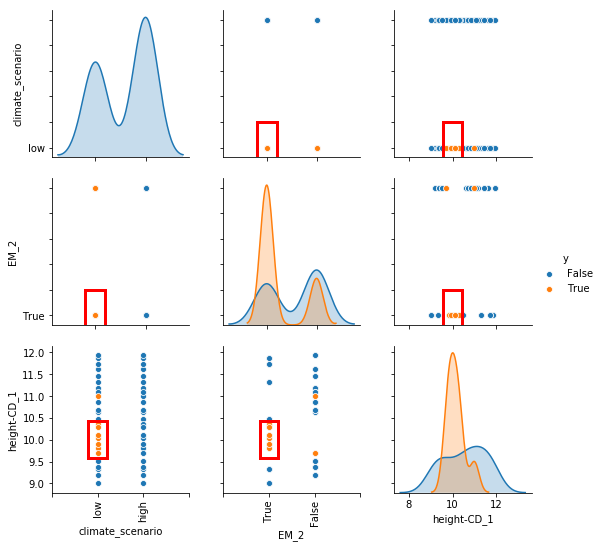

In [8]:
box1.show_pairs_scatter()
pyplot.show()